In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = 'C:\\Users\\Maruthi\\Desktop\\Trainset'
IMG_SIZE = 100
LR = 1e-3
MODEL_NAME = 'Miniproject-test-2'

In [3]:
TEST_DIR="C:\\Users\\Maruthi\\Desktop\\testset"

In [4]:
def label_img(img):
    l=[0]*15
    l[int(img.split('_')[0])-1]=1
    return l

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), 3)
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('_')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), np.array(img_num)])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


In [7]:
train_data = create_train_data()

100%|████████████████████████████████████████████████████████████████████████████| 12932/12932 [04:18<00:00, 50.08it/s]


In [8]:
test_data=process_test_data()

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 12.69it/s]


In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf 
tf.reset_default_graph() 
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)


convnet = fully_connected(convnet, 15, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
if os.path.exists("Miniproject.meta"):
    model.load(MODEL_NAME)
    print('model loaded!')

In [11]:
train=train_data[:-500]
test=train_data[-500:]

In [12]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
#X = np.expand_dims(img, axis=0)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 389  | total loss: 0.08555 | time: 154.031s
| Adam | epoch: 002 | loss: 0.08555 - acc: 0.9712 -- iter: 12416/12432
Training Step: 390  | total loss: 0.08062 | time: 157.069s
| Adam | epoch: 002 | loss: 0.08062 - acc: 0.9725 | val_loss: 0.08135 - val_acc: 0.9700 -- iter: 12432/12432
--


In [13]:
#score = model.evaluate(test_x, test_y)#, verbose=0) 
#print('loss=', score[0]) 
#print('accuracy=', score[1])

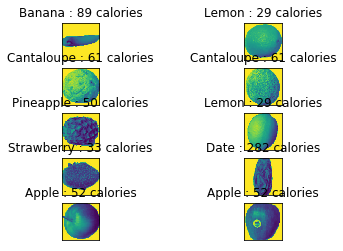

In [14]:
import matplotlib.pyplot as plt 
test_data = test
  
fig = plt.figure() 
  
for num, data in enumerate(test_data[:10]): 
    res=["Apple : 52 calories","Banana : 89 calories","Cactus Friut : 61 calories","Cantaloupe : 61 calories","Cherry : 50 calories","Date : 282 calories","Grape : 67 calories","Guava : 68 calories","Lemon : 29 calories","Mango : 60 calories","Orange : 47 calories","Papaya : 100 calories","Pineapple : 50 calories","Promeganate : 83 calories","Strawberry : 33 calories"]  
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,2,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
  #  orig.set_size_inches(18.5, 10.5) 
    y.imshow(orig)
    plt.title(res[np.argmax(model_out)])
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()